In [1]:
import tensorflow as tf
from keras import regularizers
from keras.callbacks import EarlyStopping
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

In [2]:
# Setting the random seed so there is consistent data splitting between runs
tf.random.set_seed(42)
# importing the lowPPM matrix
allData = r"../Output/LowPPMMatrix.csv"

# Reading in the data to csv and removing any data at 150 ppm as this was incorrect data from testing
# NOTE: the 150 ppm is not in all outputs. but it is left in as a safeguard
df = pd.read_csv(allData)
df=df[df['Target PPM']!=150]
# Dropping all unneeded columns from the output
df = df.drop(columns=['Unnamed: 0','lowInterval','highInterval','Ratio'])
print(df.head())

# Declaring what sensor is used for the test set
test_sensor_id = 0  # Replace with the ID of the sensor you want in the test set
train_data = df[df['SensorID'] != test_sensor_id]
test_data = df[df['SensorID'] == test_sensor_id]

# Drop the SensorID column as we don't need it anymore
train_data = train_data.drop(columns=['SensorID'])
test_data = test_data.drop(columns=['SensorID'])
# Convert to TensorFlow tensors
train_data_tf = tf.convert_to_tensor(train_data, dtype=tf.float32)
test_data_tf = tf.convert_to_tensor(test_data, dtype=tf.float32)

   SensorID  Target PPM  Resistance  Temperature  RelativeHumidity
0       0.0         0.0   30.009404     0.795619          6.227832
1       3.0         0.0   28.086765     0.795619          6.227832
2       5.0         0.0   30.475486     0.795619          6.227832
3       7.0         0.0   31.911561     0.795619          6.227832
4       8.0         0.0   26.515605     0.795619          6.227832


In [3]:
# Randomizes the data for training to minimize fitting to false trends
train_data_shuffled = tf.random.shuffle(train_data_tf, seed=42)

# Separate features and labels
x_train, y_train = train_data_shuffled[:, 1:], train_data_shuffled[:, 0]
x_test, y_test = test_data_tf[:, 1:], test_data_tf[:, 0]

In [4]:


@keras.saving.register_keras_serializable()
def mse_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@keras.saving.register_keras_serializable()
def rmse(y_true, y_pred):
    return tf.sqrt(mse_loss(y_pred, y_true))

@keras.saving.register_keras_serializable()
def r_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

# Used to trace history of RMSE as the neural network gets trained
class RMSEHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        if logs is None:
            logs = {}
        self.modelRMSE = []
        self.validationRMSE = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.modelRMSE.append(logs.get('rmse'))
        self.validationRMSE.append(logs.get('val_rmse'))

In [5]:
rmse_history = RMSEHistory()
# Compile and train the model
input_shape = (x_train.shape[1],)

In [ ]:
# Initialize a CSV file to store the results
csvfile = open('experiment_results.csv', 'w', newline='')
csvwriter = csv.writer(csvfile)
csvwriter.writerow(['BaseNum', 'Run', 'Test_RMSE', 'Test_Accuracy'])

for baseNum in tqdm(range(1, 16), desc='BaseNum Loop'):  # Wrap outer loop with tqdm
    for run in tqdm(range(1, 101), desc=f'Run Loop for BaseNum {baseNum}', leave=False):  # Wrap inner loop with tqdm

# Define your original model with regularization
        def build_model(input_shape, regularization_factor=0.01):
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(baseNum*2, activation='elu', kernel_regularizer=regularizers.l2(regularization_factor), input_shape=input_shape),
                tf.keras.layers.Dense(baseNum*4, activation='mish', kernel_regularizer=regularizers.l2(regularization_factor)),
                tf.keras.layers.Dense(baseNum*4, activation='elu', kernel_regularizer=regularizers.l2(regularization_factor)),
                tf.keras.layers.Dense(baseNum*2, activation='linear', kernel_regularizer=regularizers.l2(regularization_factor)),
        # tf.keras.layers.Dense(baseNum, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
                tf.keras.layers.Dense(1)
            ])
            return model

        with tf.device('/GPU:0'):
            model = build_model(input_shape)
            model.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])
            model.fit(x_train, y_train, epochs=1000, batch_size=50, validation_split=0.2, callbacks=[rmse_history],verbose=0)
            test_metrics = model.evaluate(x_test, y_test,verbose=0)
            test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
        # Save the results
        csvwriter.writerow([baseNum, run, test_rmse, test_accuracy])
        csvfile.flush()
csvfile.close()

In [ ]:
df1 = pd.read_csv("./experiment_results.csv")

# Create a figure and axis object for the boxplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Create a boxplot for Test_RMSE grouped by BaseNum
df1.boxplot(column='Test_RMSE', by='BaseNum', ax=ax[0])
ax[0].set_title('Boxplot of Test_RMSE Grouped by BaseNum')
ax[0].set_xlabel('BaseNum')
ax[0].set_ylabel('Test_RMSE')

# Create a boxplot for Test_Accuracy grouped by BaseNum
df1.boxplot(column='Test_Accuracy', by='BaseNum', ax=ax[1])
ax[1].set_title('Boxplot of Test_Accuracy Grouped by BaseNum')
ax[1].set_xlabel('BaseNum')
ax[1].set_ylabel('Test_Accuracy')

# Show the plots
plt.suptitle('Boxplots Grouped by BaseNum')
plt.show()

# Group by BaseNum and calculate the mean
grouped_means = df1.groupby('BaseNum').mean()

# Create a figure and axis objects
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the mean of Test_RMSE
ax[0].plot(grouped_means.index, grouped_means['Test_RMSE'], label='Test_RMSE', marker='o')
ax[0].set_xlabel('BaseNum')
ax[0].set_ylabel('Mean of Test_RMSE')
ax[0].set_title('Mean of Test_RMSE Grouped by BaseNum')
ax[0].legend()

# Plot the mean of Test_Accuracy
ax[1].plot(grouped_means.index, grouped_means['Test_Accuracy'], label='Test_Accuracy', marker='x')
ax[1].set_xlabel('BaseNum')
ax[1].set_ylabel('Mean of Test_Accuracy')
ax[1].set_title('Mean of Test_Accuracy Grouped by BaseNum')
ax[1].legend()

# Show the plot
plt.show()

In [7]:
import random
from keras.src.losses import mean_squared_error

activation_functions = ['relu', 'sigmoid', 'elu', 'selu', 'swish', 'linear']

best_activation = None
lowest_mse = float('inf')
baseNum = 4
n=100
def build_model(input_shape, activations, regularization_factor=0.01,):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(baseNum*2, activation=activations[0], kernel_regularizer=regularizers.l2(regularization_factor), input_shape=input_shape),
        tf.keras.layers.Dense(baseNum*4, activation=activations[1], kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(baseNum*4, activation=activations[2], kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(baseNum*2, activation=activations[3], kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(1)
    ])
    return model
for _ in tqdm(range(n), desc='BaseNum Loop'):
    # Randomly select activation functions for each layer
    activation = [random.choice(activation_functions) for _ in range(4)]
    rmse_list = []

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    for _ in range(int(n/4)):
        # Create and train the model
        with tf.device('/GPU:0'):
    #regular model training
            model = build_model(input_shape,activation)
            model.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])
            model.fit(x_train, y_train, epochs=1000, batch_size=50, validation_split=0.2, callbacks=[early_stopping,rmse_history],verbose=0)

        # Evaluate on validation data
            y_val_pred = model.predict(x_test,verbose=0)
            rmse1 = rmse(y_test, y_val_pred)
            rmse_list.append(rmse1)

    # Average RMSE for this sequence of activations
    avg_rmse = np.mean(rmse_list)
    print(f"Average RMSE with activations {activation}: {avg_rmse}")

    # Update the best activation function if needed
    if avg_rmse < lowest_mse:
        best_activation = activation
        lowest_mse = avg_rmse

print(f"Best activation function is {best_activation} with RMSE {lowest_mse}")

BaseNum Loop:   1%|          | 1/100 [02:00<3:19:09, 120.70s/it]

Average RMSE with activations ['swish', 'selu', 'relu', 'relu']: 23.442481994628906


BaseNum Loop:   1%|          | 1/100 [02:28<4:04:41, 148.30s/it]


KeyboardInterrupt: 

Epoch 1/500
11/11 [==============================] - 0s 6ms/step - loss: 973.9536 - r_squared: -2.1959 - rmse: 31.0882 - val_loss: 651.6760 - val_r_squared: -1.5410 - val_rmse: 25.4751
Epoch 2/500
11/11 [==============================] - 0s 1ms/step - loss: 687.3342 - r_squared: -1.1845 - rmse: 25.9520 - val_loss: 455.9091 - val_r_squared: -0.7635 - val_rmse: 21.2297
Epoch 3/500
11/11 [==============================] - 0s 2ms/step - loss: 508.4787 - r_squared: -0.6200 - rmse: 22.2104 - val_loss: 350.7120 - val_r_squared: -0.3481 - val_rmse: 18.5627
Epoch 4/500
11/11 [==============================] - 0s 1ms/step - loss: 408.6887 - r_squared: -0.3448 - rmse: 20.1152 - val_loss: 298.8017 - val_r_squared: -0.1455 - val_rmse: 17.1094
Epoch 5/500
11/11 [==============================] - 0s 1ms/step - loss: 355.7088 - r_squared: -0.1397 - rmse: 18.8018 - val_loss: 279.2063 - val_r_squared: -0.0716 - val_rmse: 16.5470
Epoch 6/500
11/11 [==============================] - 0s 1ms/step - loss: 32

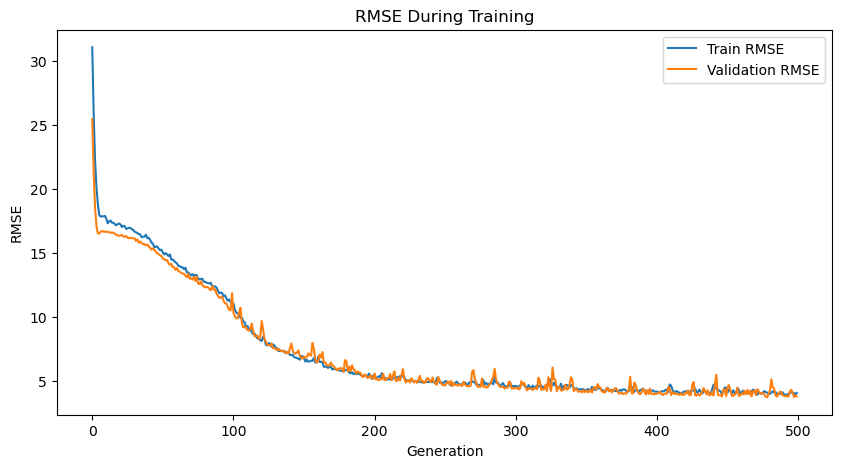

Epoch 1/200
11/11 [==============================] - 1s 8ms/step - loss: 22.8467 - r_squared: 0.9272 - rmse: 4.6523 - val_loss: 17.2796 - val_r_squared: 0.9358 - val_rmse: 4.0376
Epoch 2/200
11/11 [==============================] - 0s 2ms/step - loss: 17.4199 - r_squared: 0.9467 - rmse: 3.9752 - val_loss: 16.9484 - val_r_squared: 0.9371 - val_rmse: 3.9933
Epoch 3/200
11/11 [==============================] - 0s 2ms/step - loss: 16.2621 - r_squared: 0.9478 - rmse: 3.9087 - val_loss: 16.1540 - val_r_squared: 0.9404 - val_rmse: 3.8931
Epoch 4/200
11/11 [==============================] - 0s 2ms/step - loss: 16.0994 - r_squared: 0.9483 - rmse: 3.9022 - val_loss: 16.7155 - val_r_squared: 0.9379 - val_rmse: 3.9683
Epoch 5/200
11/11 [==============================] - 0s 2ms/step - loss: 18.2511 - r_squared: 0.9439 - rmse: 4.1616 - val_loss: 15.9067 - val_r_squared: 0.9417 - val_rmse: 3.8488
Epoch 6/200
11/11 [==============================] - 0s 2ms/step - loss: 17.6641 - r_squared: 0.9439 - rm

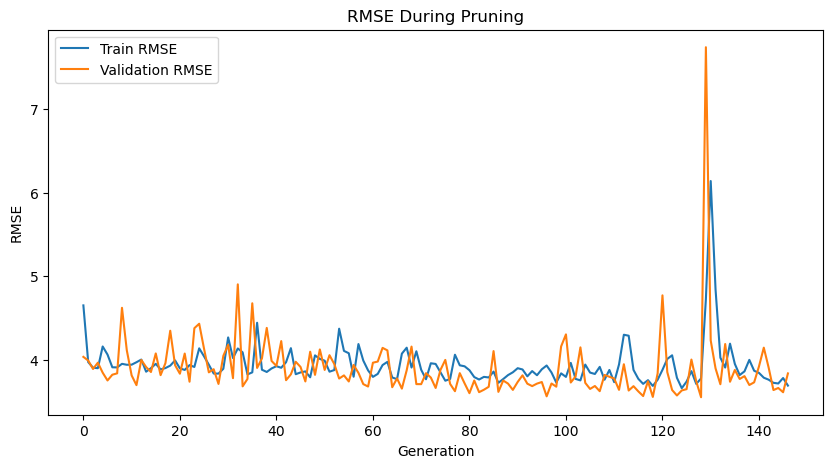

In [12]:
# NOTE: with =2 (Or any small int) it is hit or miss whether the model will go down the best optimized path. rerun a few times to determine what the best value is
#Used to quickly change size of neural net
baseNum = 4

# Define your original model with regularization
def build_model(input_shape, regularization_factor=0.01):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(baseNum*2, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor), input_shape=input_shape),
        tf.keras.layers.Dense(baseNum*4, activation='elu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(baseNum*4, activation='elu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(baseNum*2, activation='linear', kernel_regularizer=regularizers.l2(regularization_factor)),
        # tf.keras.layers.Dense(baseNum, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(1)
    ])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

with tf.device('/GPU:0'):
    #regular model training
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])
    model.fit(x_train, y_train, epochs=500, batch_size=50, validation_split=0.2, callbacks=[early_stopping,rmse_history])
    # if no improvement has been made in 100 generations (epochs) stop the model
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping occurred at epoch {early_stopping.stopped_epoch}")
        print(f"Restoring model weights from the end of the best epoch.")
    else:
        print("Early stopping did not occur.")

    test_metrics = model.evaluate(x_test, y_test)
    test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test Accuracy: {test_accuracy*100}")
    print(f"Test RMSE: {test_rmse}")
    # Plotting RMSE values
    plt.figure(figsize=(10, 5))
    plt.plot(rmse_history.modelRMSE, label='Train RMSE')
    plt.plot(rmse_history.validationRMSE, label='Validation RMSE')
    plt.xlabel('Generation')
    plt.ylabel('RMSE')
    plt.title('RMSE During Training')
    plt.legend()
    plt.show()

    # Pruning model. use the final_sparsity to trim the model. 0.5 means 50% of the nodes get trimmed, 0.9 means 90% of the nodes get trimmed. typically 0.6 is a good starting point for this when using large models
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.0,
                                                    final_sparsity=0.4,
                                                    begin_step=len(x_train) // 50 * 10,
                                                    end_step=len(x_train) // 50 * 500)
    }

    model_for_pruning = sparsity.prune_low_magnitude(model, **pruning_params)
    model_for_pruning.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared,rmse])

    callbacks = [
        sparsity.UpdatePruningStep(),
        early_stopping,
        rmse_history
    ]

    model_for_pruning.fit(x_train, y_train, epochs=200, batch_size=50, validation_split=0.2, callbacks=callbacks)

    # Remove the pruning wrappers to finalize the model
    modelFinal = sparsity.strip_pruning(model_for_pruning)
    modelFinal.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])

if early_stopping.stopped_epoch > 0:
    print(f"Early stopping occurred at epoch {early_stopping.stopped_epoch}")
    print(f"Restoring model weights from the end of the best epoch.")
else:
    print("Early stopping did not occur.")

# Make predictions
with tf.device('/GPU:0'):  # This line is optional
    test_metrics = modelFinal.evaluate(x_test, y_test)
    test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test Accuracy: {test_accuracy*100}")
    print(f"Test RMSE: {test_rmse}")


# Plotting RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_history.modelRMSE, label='Train RMSE')
plt.plot(rmse_history.validationRMSE, label='Validation RMSE')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.title('RMSE During Pruning')
plt.legend()
plt.show()
# model.save('MethaneModel.keras')

In [38]:
# Used to save the model
# model.compile(optimizer='adam', loss='mse')
# model.save('BestMethaneModel292-968-4nodes.h5')

/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 783us/step


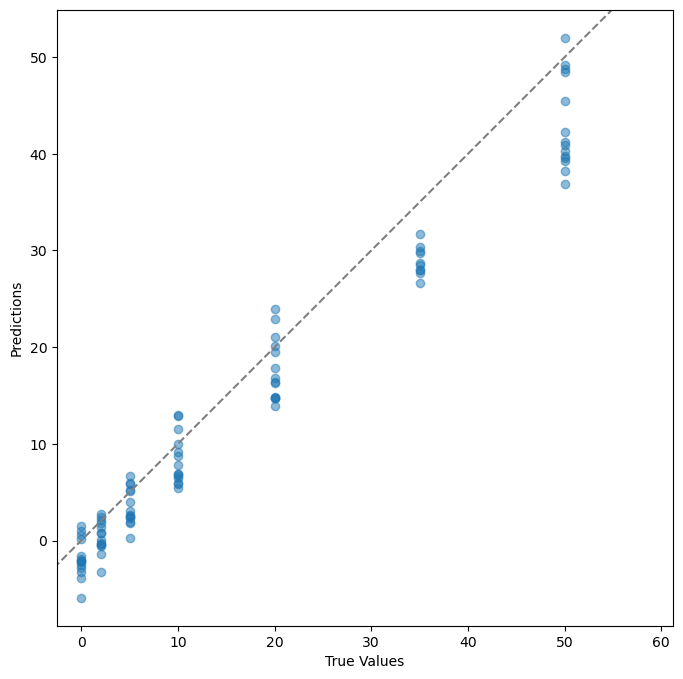

In [13]:
import matplotlib.pyplot as plt

# Generate predictions on the test data
with tf.device('/GPU:0'):  # Optional
    y_pred = model.predict(x_test)

# Flatten y_test and y_pred for plotting
y_test_flat = y_test.numpy().flatten()
y_pred_flat = y_pred.flatten()

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_flat, y_pred_flat, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')

# Plot a 45-degree line for reference
plt.plot([-100, 1200], [-100, 1200], '--', color='gray')

plt.show()


In [14]:
print(df.columns)

Index(['SensorID', 'Target PPM', 'Resistance', 'Temperature',
       'RelativeHumidity'],
      dtype='object')


31250/31250 [==============================] - 7s 212us/step


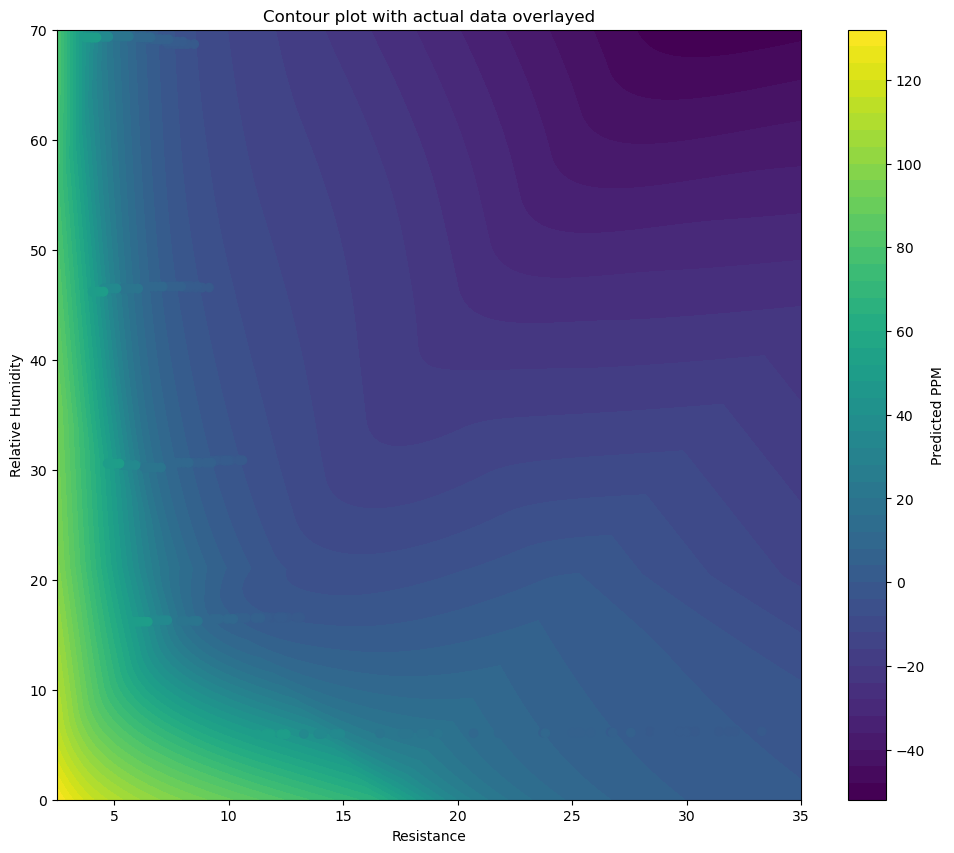

In [15]:
# Generate a grid for contour plotting
resistance_range = np.linspace(2.5, 35, 1000)
rh_range = np.linspace(0, 70, 1000)
temp = 20

# Create a grid (meshgrid) of Resistance and Relative Humidity values
resistance_values, rh_values = np.meshgrid(resistance_range, rh_range)

# Flatten the 2D arrays to 1D arrays
flat_resistance = resistance_values.ravel()
flat_rh = rh_values.ravel()

# Create a constant array filled with the temperature value
flat_temp = np.full_like(flat_resistance, temp)

# Prepare the grid data for prediction
grid_data = np.column_stack((flat_resistance, flat_temp, flat_rh))
grid_data_tf = tf.convert_to_tensor(grid_data, dtype=tf.float32)

# Use the trained model to make predictions on the grid
with tf.device('/GPU:0'):
    pred_ppm = model.predict(grid_data_tf)

# Reshape the predicted data to match the grid shape
pred_ppm = pred_ppm.reshape(resistance_values.shape)

# Create contour plot
plt.figure(figsize=(12, 10))

# Defining color range limits
vmin_val = min(pred_ppm.min(), df['Target PPM'].min())
vmax_val = max(pred_ppm.max(), df['Target PPM'].max())

contour = plt.contourf(resistance_range, rh_range, pred_ppm, 50, cmap='viridis', vmin=vmin_val, vmax=vmax_val)
plt.colorbar(label='Predicted PPM')

# Overlay actual data points
filtered_df = df[(df['Temperature'] >= temp-5) & (df['Temperature'] <= temp+5)]

# Plotting
plt.scatter(filtered_df['Resistance'], filtered_df['RelativeHumidity'], c=filtered_df['Target PPM'], cmap='viridis', vmin=vmin_val, vmax=vmax_val)


# Labels and title
plt.xlabel('Resistance')
plt.ylabel('Relative Humidity')
plt.title('Contour plot with actual data overlayed')

plt.show()


31250/31250 [==============================] - 6s 186us/step


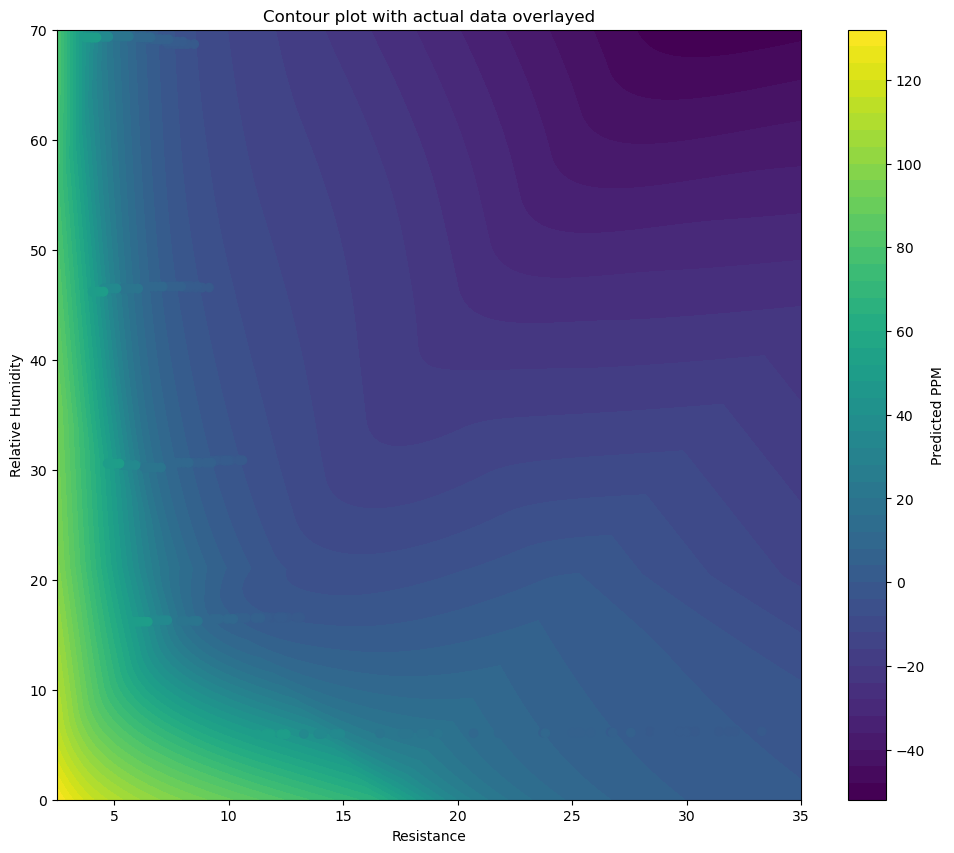

In [16]:
# Generate a grid for contour plotting
resistance_range = np.linspace(2.5, 35, 1000)
rh_range = np.linspace(0, 70, 1000)
temp = 20

# Create a grid (meshgrid) of Resistance and Relative Humidity values
resistance_values, rh_values = np.meshgrid(resistance_range, rh_range)

# Flatten the 2D arrays to 1D arrays
flat_resistance = resistance_values.ravel()
flat_rh = rh_values.ravel()

# Create a constant array filled with the temperature value
flat_temp = np.full_like(flat_resistance, temp)

# Prepare the grid data for prediction
grid_data = np.column_stack((flat_resistance, flat_temp, flat_rh))
grid_data_tf = tf.convert_to_tensor(grid_data, dtype=tf.float32)

# Use the trained model to make predictions on the grid
with tf.device('/GPU:0'):
    pred_ppm = modelFinal.predict(grid_data_tf)

# Reshape the predicted data to match the grid shape
pred_ppm = pred_ppm.reshape(resistance_values.shape)

# Create contour plot
plt.figure(figsize=(12, 10))

# Defining color range limits
vmin_val = min(pred_ppm.min(), df['Target PPM'].min())
vmax_val = max(pred_ppm.max(), df['Target PPM'].max())

contour = plt.contourf(resistance_range, rh_range, pred_ppm, 50, cmap='viridis', vmin=vmin_val, vmax=vmax_val)
plt.colorbar(label='Predicted PPM')

# Overlay actual data points
filtered_df = df[(df['Temperature'] >= temp-5) & (df['Temperature'] <= temp+5)]

# Plotting
plt.scatter(filtered_df['Resistance'], filtered_df['RelativeHumidity'], c=filtered_df['Target PPM'], cmap='viridis', vmin=vmin_val, vmax=vmax_val)


# Labels and title
plt.xlabel('Resistance')
plt.ylabel('Relative Humidity')
plt.title('Contour plot with actual data overlayed')

plt.show()


In [19]:
try:
        # Try loading the model without compiling
    loadedModel = tf.keras.models.load_model(
            "/Users/benfunk/DataspellProjects/MethaneDataScience/Ben's Analysis/BestMethaneModel292-968-4nodes.keras",custom_objects={"mse_loss": mse_loss},compile=False)
        # Then, compile the model manually
    loadedModel.compile(optimizer='adam', loss=mse_loss)
except Exception as e2:
    print(f"Failed again due to: {e2}")

339/339 [==============================] - 0s 217us/step


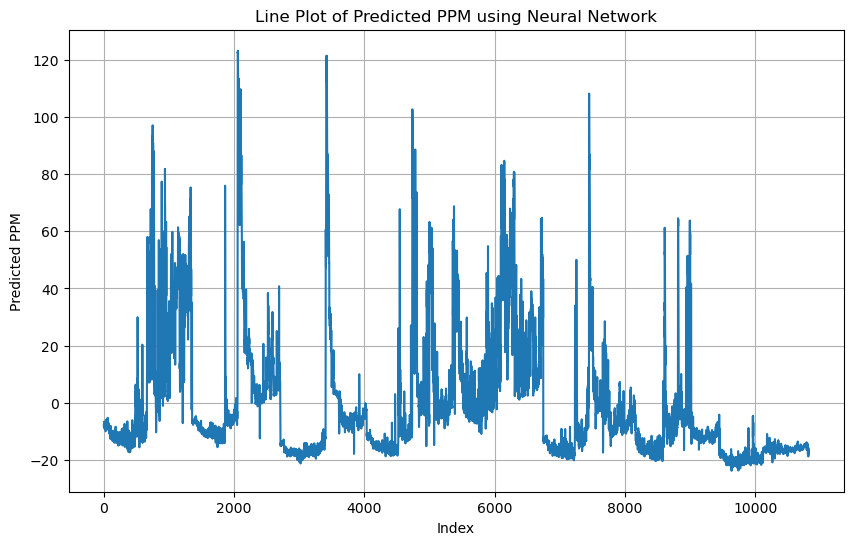

In [23]:
testData = pd.read_csv('../BPX Data/ngwef0002_20230830_alarmconditions.csv')
tempResistance = ((testData['METHANELEL_VDC'] * (5 - testData['METHANE_VDC'])) / ((testData['METHANE_VDC']) * (5 - testData['METHANELEL_VDC'])))
calculatedResistance = pd.DataFrame(tempResistance, columns=['Resistance'])
temp = testData["AMBIENTTEMP_C"]
humid = testData["AMBIENT_RH"]
final_test_data = pd.concat([calculatedResistance, temp, humid], axis=1)

predictions = loadedModel.predict(final_test_data)
if len(predictions.shape) == 2 and predictions.shape[1] == 1:
    predictions = predictions.flatten()

# Create an index list
index_list = list(range(len(predictions)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(index_list, predictions, linestyle='-')
plt.xlabel('Index')
plt.ylabel('Predicted PPM')
plt.title('Line Plot of Predicted PPM using Neural Network')
plt.grid(True)
plt.show()

338/338 [==============================] - 0s 217us/step


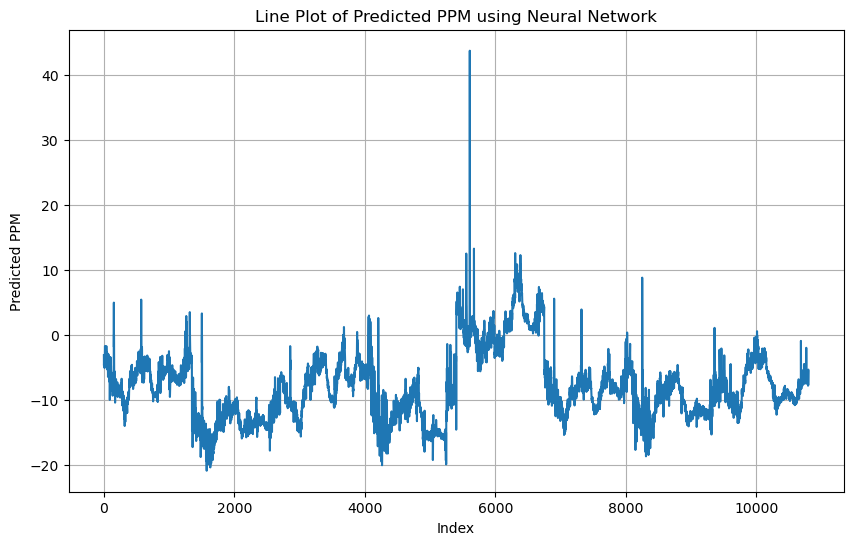

In [24]:
testData = pd.read_csv('../BPX Data/ngwpermms005_20230831_normalconditions.csv')
tempResistance = ((testData['METHANELEL_VDC'] * (5 - testData['METHANE_VDC'])) / ((testData['METHANE_VDC']) * (5 - testData['METHANELEL_VDC'])))
calculatedResistance = pd.DataFrame(tempResistance, columns=['Resistance'])
temp = testData["AMBIENTTEMP_C"]
humid = testData["AMBIENT_RH"]
final_test_data = pd.concat([calculatedResistance, temp, humid], axis=1)

predictions = loadedModel.predict(final_test_data)
if len(predictions.shape) == 2 and predictions.shape[1] == 1:
    predictions = predictions.flatten()

# Create an index list
index_list = list(range(len(predictions)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(index_list, predictions, linestyle='-')
plt.xlabel('Index')
plt.ylabel('Predicted PPM')
plt.title('Line Plot of Predicted PPM using Neural Network')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 6ms/step


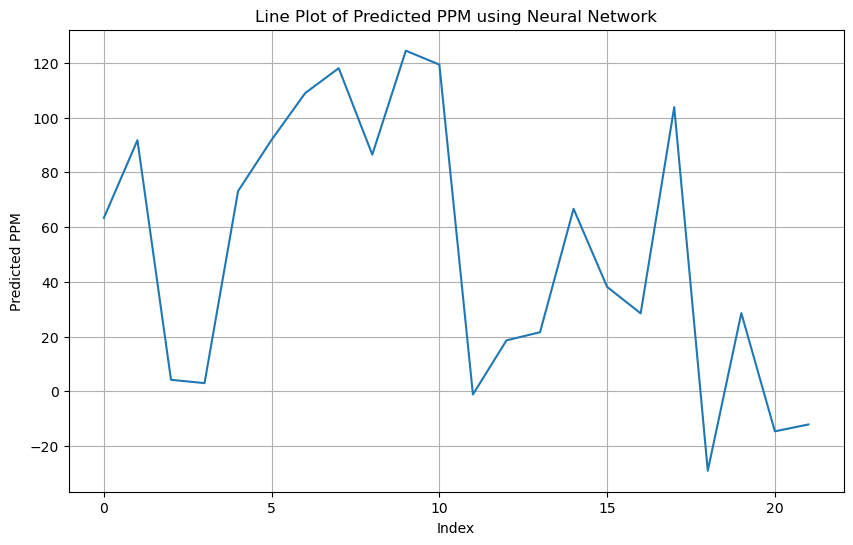

In [25]:
testData = pd.read_csv('../BPX Data/range_testvalues_20230601_20230828.csv')
tempResistance = ((testData['METHANELEL_VDC'] * (5 - testData['METHANE_VDC'])) / ((testData['METHANE_VDC']) * (5 - testData['METHANELEL_VDC'])))
calculatedResistance = pd.DataFrame(tempResistance, columns=['Resistance'])
temp = testData["AMBIENTTEMP_C"]
humid = testData["AMBIENT_RH"]
final_test_data = pd.concat([calculatedResistance, temp, humid], axis=1)

predictions = loadedModel.predict(final_test_data)
if len(predictions.shape) == 2 and predictions.shape[1] == 1:
    predictions = predictions.flatten()

# Create an index list
index_list = list(range(len(predictions)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(index_list, predictions, linestyle='-')
plt.xlabel('Index')
plt.ylabel('Predicted PPM')
plt.title('Line Plot of Predicted PPM using Neural Network')
plt.grid(True)
plt.show()

17271/17271 [==============================] - 3s 182us/step


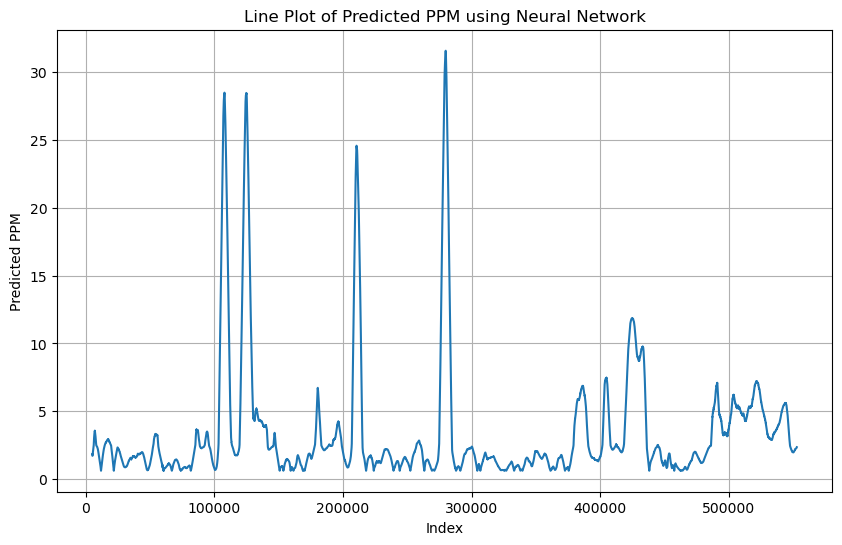

In [42]:
testData = pd.read_csv('../Raw Data/CorrectedLog.csv')
def placeholder_function(vout, vref):
    return (vref*(5-vout))/(vout*(5-vref))  # Example placeholder function

# Calculate the time difference in days since the first row (assuming each row is 5 seconds)
df1 = pd.DataFrame()
df2 = pd.DataFrame()
# Iterate through the Vout and Vref columns to create rr columns
for i in range(8):
    vout_col = f'Vout_{i}'
    vref_col = f'Vref_{i}'
    rr_col = f'rr_{i}'

    df1[rr_col] = testData.apply(lambda row: placeholder_function(row[vout_col], row[vref_col]), axis=1)
    df2[rr_col] = df1[rr_col].rolling(window=5000).mean()  # Apply rolling average


calculatedResistance = df2.mean(axis=1)


T = 23
H = 40

# New DataFrame to store calculated values
fixed_temp = pd.Series([T]*len(calculatedResistance), name='FixedTemp')
fixed_humid = pd.Series([H]*len(calculatedResistance), name='FixedHumid')

final_test_data = pd.concat([calculatedResistance.reset_index(drop=True), fixed_temp, fixed_humid], axis=1)

# Perform prediction
predictions = loadedModel.predict(final_test_data)
if len(predictions.shape) == 2 and predictions.shape[1] == 1:
    predictions = predictions.flatten()

# Create an index list
index_list = list(range(len(predictions)))
df2['Days'] = df['Days']
first_4_days_df = df2[df2['Days'] < 1]

# Calculate the mean of all columns for each of the first days
daily_averages = first_4_days_df[rr_col].mean(axis=1)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(index_list, predictions+45, linestyle='-')
plt.xlabel('Index')
plt.ylabel('Predicted PPM')
plt.title('Line Plot of Predicted PPM using Neural Network')
plt.grid(True)
plt.show()